# Comorbidity analysis with drugs

In [1]:
import difflib
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import *
import seaborn as sns

%matplotlib inline

## Medication database

In [64]:
ds = pd.read_csv('../output/medications/data.csv', low_memory=False)
ds['ATC_CODE_3'] = ds['ATC_CODE'].str[0:3]
ds_drop = ds.drop('entity_id', 1).dropna()

In [65]:
ds = ds.drop('CONDITION', 1)
ds = ds.drop('DRUG_NAME', 1)
ds = ds.drop('ATC_CODE', 1)

In [66]:
ds_drop = ds.drop_duplicates()
ds_drop['COUNT'] = 1

/software/debian-8/general/virtenvs/jupyter/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [67]:
ds_drop = pd.pivot_table(ds_drop, index='entity_id', columns='ATC_CODE_3', values='COUNT', aggfunc=np.sum)
ds_drop = ds_drop.fillna(0)
ds_drop.as_matrix()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

## Calculate comorbidity frequency

In [68]:
ds_asint = ds_drop.astype(int)
coocurrences = ds_asint.T.dot(ds_asint).as_matrix()
coocurrences

array([[494,   9,   3, ...,   1,   0,   1],
       [  9,  19,   0, ...,   0,   0,   0],
       [  3,   0,   6, ...,   0,   0,   0],
       ..., 
       [  1,   0,   0, ...,   2,   0,   0],
       [  0,   0,   0, ...,   0,   2,   0],
       [  1,   0,   0, ...,   0,   0,   1]])

## Relative Risk

The Relative Risk (RR) of observing a pair of diseases $i$ and $j$ affecting the same patient is given by

$$RR_ij = \frac{C_ijN}{P_iP_j}$$ where $C_ij$ is the number of patients affected by both diseases, $N$ is the total number of patients in the population and $P_i$ and $P_j$ are the prevalences of diseases $i$ and $j$.

In [69]:
from __future__ import division

def RR(c, N, i, j):
    if (c[i,i]*c[j,j] == 0):
        return(0)
    if (i == j):
        return 0
    return (c[i,j]*N)/(c[i,i]*c[j,j])

In [115]:
N = ds_asint.shape[0]
risk = coocurrences.copy().astype(float)

for i in range(0, coocurrences.shape[0], 1):
    for j in range(0, coocurrences.shape[1], 1):
        risk[i,j] = RR(coocurrences, N, i, j)
        
risk = pd.DataFrame(risk, index=ds_drop.columns, columns=ds_drop.columns)

In [123]:
aux = risk
aux['sum'] = aux.sum()
aux = aux[aux['sum'] > 100]
aux = aux.drop('sum', 1)
aux = aux[aux.index.values]
aux.to_csv('../output/relative-risk/data.csv')

## Plot disease relative risk matrix

<module 'matplotlib.pyplot' from '/software/debian-8/general/virtenvs/jupyter/lib/python3.5/site-packages/matplotlib/pyplot.py'>

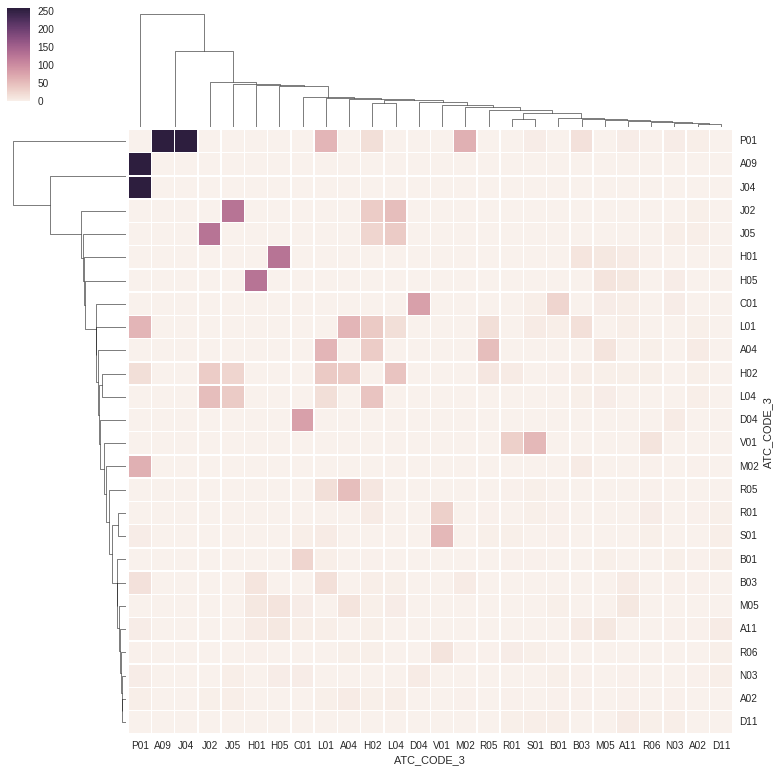

In [122]:
df = aux
cg = sns.clustermap(df, linewidths=.5, figsize=(13, 13))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt